In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [74]:
df = pd.read_csv('/Users/leopoldhuang/Desktop/data1030-fall2025/data/psd_coffee.csv')
print("\nINITIAL DATA INSPECTION")
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("\nFIRST 5 ROWS")
print(df.head())
print("\nDATA TYPES")
print(df.dtypes)
print("\nSTATISTICAL SUMMARY")
print(df.describe())


INITIAL DATA INSPECTION
Dataset shape: (85937, 12)
Number of rows: 85937
Number of features: 12

FIRST 5 ROWS
   Commodity_Code Commodity_Description Country_Code Country_Name  \
0          711100         Coffee, Green           AL      Albania   
1          711100         Coffee, Green           AL      Albania   
2          711100         Coffee, Green           AL      Albania   
3          711100         Coffee, Green           AL      Albania   
4          711100         Coffee, Green           AL      Albania   

   Market_Year  Calendar_Year  Month  Attribute_ID Attribute_Description  \
0         2005           2023      6            29    Arabica Production   
1         2005           2023      6            90          Bean Exports   
2         2005           2023      6            58          Bean Imports   
3         2005           2023      6            20      Beginning Stocks   
4         2005           2023      6           125  Domestic Consumption   

   Unit_ID   Unit

In [75]:
print("MISSING VALUE ANALYSIS")
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])
total_cells = np.prod(df.shape)
total_missing = missing_values.sum()
print(f"\nTotal missing cells: {total_missing}")
print(f"Fraction of dataset that is missing: {total_missing/total_cells:.4f}")

MISSING VALUE ANALYSIS

Missing values per column:
Series([], dtype: int64)

Total missing cells: 0
Fraction of dataset that is missing: 0.0000


In [76]:
print("FEATURE ENGINEERING")
def calculate_stu(df, year):
    year_data = df[df['Market_Year'] == year]
    production = year_data[year_data['Attribute_Description'] == 'Production']['Value'].sum()
    consumption = year_data[year_data['Attribute_Description'] == 'Domestic Consumption']['Value'].sum()
    ending_stocks = year_data[year_data['Attribute_Description'] == 'Ending Stocks']['Value'].sum()
    exports = year_data[year_data['Attribute_Description'] == 'Exports']['Value'].sum()
    total_use = consumption + exports
    stu = ending_stocks / total_use if total_use > 0 else 0
    return stu, production, consumption, ending_stocks
years = df['Market_Year'].unique()
recent_years = sorted(years)[-6:]
print("Stock to Use Analysis:")
for year in recent_years:
    stu, prod, cons, stocks = calculate_stu(df, year)
    print(f"Year {year}: STU={stu:.3f}, Production={prod:.0f}, Consumption={cons:.0f}")
    if stu < 0.20:
        print(f"Low STU - Price risk")

FEATURE ENGINEERING
Stock to Use Analysis:
Year 2020: STU=0.122, Production=176549, Consumption=162093
Low STU - Price risk
Year 2021: STU=0.103, Production=165044, Consumption=167868
Low STU - Price risk
Year 2022: STU=0.089, Production=164389, Consumption=168789
Low STU - Price risk
Year 2023: STU=0.075, Production=169345, Consumption=163921
Low STU - Price risk
Year 2024: STU=0.069, Production=174395, Consumption=166515
Low STU - Price risk
Year 2025: STU=0.072, Production=178680, Consumption=169363
Low STU - Price risk


EXPLORATORY DATA ANALYSIS - VISUALIZATIONS


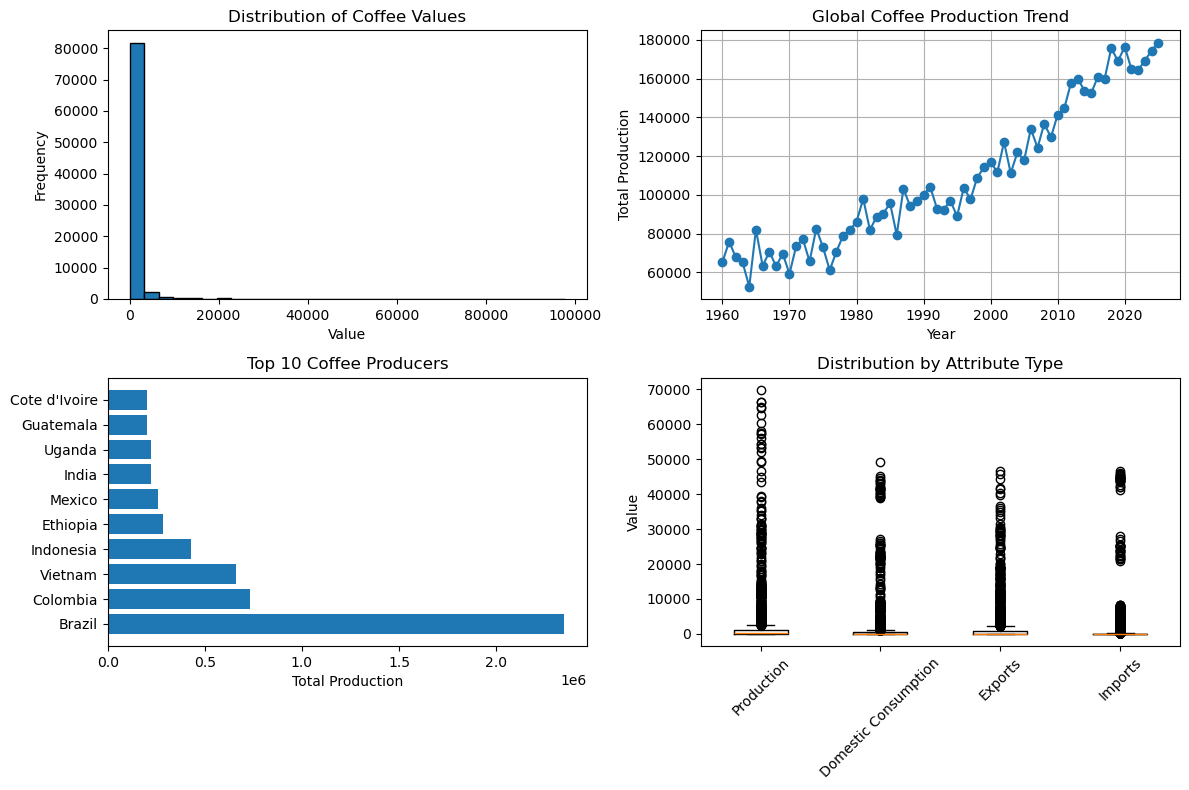

In [113]:
print("EXPLORATORY DATA ANALYSIS - VISUALIZATIONS")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Plot 1: Distribution of Values
ax1 = axes[0, 0]
ax1.hist(df['Value'], bins=30, edgecolor='black')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Coffee Values')
# Plot 2: Production over time
ax2 = axes[0, 1]
prod_by_year = df[df['Attribute_Description'] == 'Production'].groupby('Market_Year')['Value'].sum()
ax2.plot(prod_by_year.index, prod_by_year.values, marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Production')
ax2.set_title('Global Coffee Production Trend')
ax2.grid(True)
# Plot 3: Top producing countries
ax3 = axes[1, 0]
top_countries = df[df['Attribute_Description'] == 'Production'].groupby('Country_Name')['Value'].sum().nlargest(10)
ax3.barh(range(len(top_countries)), top_countries.values)
ax3.set_yticks(range(len(top_countries)))
ax3.set_yticklabels(top_countries.index)
ax3.set_xlabel('Total Production')
ax3.set_title('Top 10 Coffee Producers')
# Plot 4: Box plot of values by attribute type
ax4 = axes[1, 1]
main_attributes = ['Production', 'Domestic Consumption', 'Exports', 'Imports']
data_for_box = [df[df['Attribute_Description'] == attr]['Value'].values                 
                for attr in main_attributes]
ax4.boxplot(data_for_box, tick_labels=main_attributes)
ax4.set_ylabel('Value')
ax4.set_title('Distribution by Attribute Type')
ax4.set_xticklabels(main_attributes, rotation=45)
plt.tight_layout()
plt.show()

In [114]:
print("DATA PREPARATION FOR MODELING")
numerical_features = ['Market_Year', 'Calendar_Year', 'Month', 'Attribute_ID', 'Unit_ID']
categorical_features = ['Country_Name', 'Country_Code', 'Attribute_Description']
all_feature_cols = numerical_features + categorical_features
X = df[all_feature_cols].copy()
y = df['Value'].copy()
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

print("\nData types verification:")
for col in all_feature_cols:
    dtype = X[col].dtype
    sample_value = X[col].iloc[0]
    print(f"{col}: {dtype} (sample: {sample_value})")

print("\nExample of feature ranges:")
print(f"Month: {X['Month'].min()}-{X['Month'].max()}")
print(f"Market_Year: {X['Market_Year'].min()}-{X['Market_Year'].max()}")
print(f"Country_Code: {X['Country_Code'].nunique()} unique values")
print(f"Country_Name: {X['Country_Name'].nunique()} unique values")

DATA PREPARATION FOR MODELING
Feature matrix shape: (85937, 8)
Target shape: (85937,)

Data types verification:
Market_Year: int64 (sample: 2005)
Calendar_Year: int64 (sample: 2023)
Month: int64 (sample: 6)
Attribute_ID: int64 (sample: 29)
Unit_ID: int64 (sample: 2)
Country_Name: object (sample: Albania)
Country_Code: object (sample: AL)
Attribute_Description: object (sample: Arabica Production)

Example of feature ranges:
Month: 0-12
Market_Year: 1960-2025
Country_Code: 94 unique values
Country_Name: 94 unique values


In [121]:
print("Checking for Group Structure:")
country_counts = df.groupby(['Country_Name', 'Market_Year']).size()
print(f"Unique countries: {df['Country_Name'].nunique()}")
print(f"Rows per country-year: {country_counts.mean():.1f} (average)")
print(f"Example: Brazil 2023 has {len(df[(df['Country_Name']=='Brazil') & (df['Market_Year']==2023)])} rows")
print("\nChecking for Panel Data Structure:")
countries_with_multiple_years = df.groupby('Country_Name')['Market_Year'].nunique()
print(f"Countries tracked over multiple years: {(countries_with_multiple_years > 1).sum()}")
print(f"Average years per country: {countries_with_multiple_years.mean():.1f}")

#Time Series Split
# Sort by time first
df_sorted = df.sort_values(['Market_Year', 'Month', 'Country_Name'])
X_sorted = df_sorted[all_feature_cols]
y_sorted = df_sorted['Value']
cutoff_year_1 = 2020
cutoff_year_2 = 2022
X_train = X_sorted[X_sorted['Market_Year'] < cutoff_year_1]
y_train = y_sorted[X_sorted['Market_Year'] < cutoff_year_1]
X_val = X_sorted[(X_sorted['Market_Year'] >= cutoff_year_1) & (X_sorted['Market_Year'] < cutoff_year_2)]
y_val = y_sorted[(X_sorted['Market_Year'] >= cutoff_year_1) & (X_sorted['Market_Year'] < cutoff_year_2)]
X_test = X_sorted[X_sorted['Market_Year'] >= cutoff_year_2]
y_test = y_sorted[X_sorted['Market_Year'] >= cutoff_year_2]
print(f"Time-based split results:")
print(f"Train: Years < {cutoff_year_1}, {len(X_train)} samples")
print(f"Val: Years {cutoff_year_1}-{cutoff_year_2-1}, {len(X_val)} samples")
print(f"Test: Years >= {cutoff_year_2}, {len(X_test)} samples")

# Using TimeSeriesSplit for cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
X_for_cv = X_sorted.head(10000)
y_for_cv = y_sorted.head(10000)
print(f"\nTimeSeriesSplit Cross-Validation:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_for_cv)):
    train_years = X_for_cv.iloc[train_idx]['Market_Year']
    val_years = X_for_cv.iloc[val_idx]['Market_Year']
    print(f"Fold {i+1}: Train years {train_years.min()}-{train_years.max()}, "
          f"Val years {val_years.min()}-{val_years.max()}")

print(f"\nFinal Time-Based Split Results:")
print(f"Train: Years {min(train_years)}-{max(train_years)}, {len(X_train)} samples")
print(f"Val: Years {val_years}, {len(X_val)} samples")
print(f"Test: Years {test_years}, {len(X_test)} samples")

Checking for Group Structure:
Unique countries: 94
Rows per country-year: 19.0 (average)
Example: Brazil 2023 has 19 rows

Checking for Panel Data Structure:
Countries tracked over multiple years: 94
Average years per country: 48.1
Time-based split results:
Train: Years < 2020, 75335 samples
Val: Years 2020-2021, 3534 samples
Test: Years >= 2022, 7068 samples

TimeSeriesSplit Cross-Validation:
Fold 1: Train years 1960-1961, Val years 1961-1963
Fold 2: Train years 1960-1963, Val years 1963-1964
Fold 3: Train years 1960-1964, Val years 1964-1966
Fold 4: Train years 1960-1966, Val years 1966-1967
Fold 5: Train years 1960-1967, Val years 1967-1969

Final Time-Based Split Results:
Train: Years 1960-1967, 75335 samples
Val: Years 72136    1967
72137    1967
72138    1967
72139    1967
72140    1967
         ... 
33137    1969
33138    1969
33139    1969
33140    1969
33141    1969
Name: Market_Year, Length: 1666, dtype: int64, 3534 samples
Test: Years [2023, 2024, 2025], 7068 samples


In [122]:
ordinal_features = []
onehot_features = ['Country_Name', 'Attribute_Description', 'Country_Code']
minmax_features = ['Month', 'Attribute_ID', 'Unit_ID']
standard_features = ['Market_Year', 'Calendar_Year']

print("Feature categorization")
print(f"Ordinal features: {ordinal_features if ordinal_features else 'None'}")
print(f"OneHot features: {onehot_features}")
print(f"MinMax features: {minmax_features}")
print(f"Standard features: {standard_features}")

transformers = []
if ordinal_features:
    transformers.append(('ord', OrdinalEncoder(), ordinal_features))
if onehot_features:
    transformers.append(('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_features))
if minmax_features:
    transformers.append(('minmax', MinMaxScaler(), minmax_features))
if standard_features:
    transformers.append(('std', StandardScaler(), standard_features))

preprocessor = ColumnTransformer(transformers=transformers)
preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)
print(f"\nShape after preprocessing:")
print(f"X_train: {X_train.shape} -> {X_train_prep.shape}")
print(f"X_val: {X_val.shape} -> {X_val_prep.shape}")
print(f"X_test: {X_test.shape} -> {X_test_prep.shape}")

n_features_original = X_train.shape[1]
n_features_preprocessed = X_train_prep.shape[1]
print(f"\nFeature expansion: {n_features_original} -> {n_features_preprocessed}")
print(f"Original: {n_features_original} features")
print(f"After preprocessing: {n_features_preprocessed} features")
print(f"Expansion due to OneHotEncoder: {n_features_preprocessed - n_features_original} new features")

Feature categorization
Ordinal features: None
OneHot features: ['Country_Name', 'Attribute_Description', 'Country_Code']
MinMax features: ['Month', 'Attribute_ID', 'Unit_ID']
Standard features: ['Market_Year', 'Calendar_Year']

Shape after preprocessing:
X_train: (75335, 8) -> (75335, 212)
X_val: (3534, 8) -> (3534, 212)
X_test: (7068, 8) -> (7068, 212)

Feature expansion: 8 -> 212
Original: 8 features
After preprocessing: 212 features
Expansion due to OneHotEncoder: 204 new features


In [131]:
print("MODEL TRAINING")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0, random_state=RANDOM_STATE),
    'Lasso (alpha=1.0)': Lasso(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso (alpha=10.0)': Lasso(alpha=10.0, random_state=RANDOM_STATE)
}
results = {}
for name, model in models.items():
    model.fit(X_train_prep, y_train)
    y_train_pred = model.predict(X_train_prep)
    y_val_pred = model.predict(X_val_prep)
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    results[name] = {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'train_r2': train_r2,
        'val_r2': val_r2
    }
    print(f"\n{name}:")
    print(f"Train:MSE={train_mse:.2f}, R_squared={train_r2:.4f}")
    print(f"Val:MSE={val_mse:.2f}, R_squared={val_r2:.4f}")

MODEL TRAINING

Linear Regression:
Train:MSE=10204757.02, R_squared=0.3501
Val:MSE=17640898.17, R_squared=0.3444

Ridge (alpha=1.0):
Train:MSE=10204760.45, R_squared=0.3501
Val:MSE=17642377.17, R_squared=0.3443

Ridge (alpha=10.0):
Train:MSE=10205091.66, R_squared=0.3501
Val:MSE=17656273.98, R_squared=0.3438

Lasso (alpha=1.0):
Train:MSE=10217242.08, R_squared=0.3493
Val:MSE=17718232.77, R_squared=0.3415

Lasso (alpha=10.0):
Train:MSE=10428721.03, R_squared=0.3359
Val:MSE=18413335.90, R_squared=0.3157


In [134]:
best_model = models['Linear Regression']
best_model.fit(X_train_prep, y_train)
y_test_pred = best_model.predict(X_test_prep)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("FINAL TEST PERFORMANCE:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R_squared: {test_r2:.4f}")

FINAL TEST PERFORMANCE:
Test MSE: 16546542.57
Test R_squared: 0.3457
